In [1]:
import mesa
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
from plotting_functions import *

'''
Definitions for model-wide parameters that is called later in self.datacollector model_reporters
'''
def compute_dynamic_majority(self):
    agent_opinions = [agent.opinion for agent in self.model.schedule.agents]
    agreed_opinions = [i for i in agent_opinions if i <= 0.1]
    # If loop for the init call of this function, prevents divide by 0 error
    if len(agent_opinions) != 0:
        return len(agreed_opinions) / len(agent_opinions)
    else:
        return 0

def compute_majority(self):
    agent_opinions = [agent.opinion for agent in self.model.schedule.agents]
    agreed_opinions = [i for i in agent_opinions if i >= 0.9]
    # If loop for the init call of this function, prevents divide by 0 error
    if len(agent_opinions) != 0:
        return len(agreed_opinions) / len(agent_opinions)
    else:
        return 0

def compute_average_opinion(model):
    agent_opinions = [agent.opinion for agent in model.schedule.agents]
    return sum(agent_opinions)/len(agent_opinions)


'''
Standard agents intialised with:

unique_id: the unique_id for each agent
weight: w parameter to be used in SProdOp equation
opinion: initial opinion between 0 and 1, representing option 0 and option 1
alpha: the 'trust' parameter found in Bayesian updating, i,e, trust in the option being correct
epsilon: the probability of agents being subject to evidence

functions

pool_agents: returns (n = pool_size) pool of agents
SProdOp: SProdOp function as per literature
bayesian_update: Bayesian updating function as per literature
switched_bayesian: Version of Bayesian updating where the evidence switched behaviour after a certain value (currently manually inputted)

'''


class Agent(mesa.Agent):
    
        
    def __init__(self, unique_id, model, w, alpha, epsilon):
        
        super().__init__(unique_id, model)
        # Initialise each agent with an opinion on whether H1 is true. Randomly distributed between 0 and 1.
        
        if self.model.uniform == True:
            self.opinion = 0.5
            
        else:
            self.opinion = random.uniform(0,1)
            
        self.majority = 0
        # Weight is the same for each agent, since we are planning to use special case in SProdOp
        self.weight = w
        self.epsilon = epsilon
        self.alpha = alpha
        # Initialising the real time consesus reading 
    
    def pool_agents(self):
        # Return array of [agent and (n) neighbouring agents]
        pooled_agents = [self]
        # Random approach - randomly choose n agents, assumes 'Well-mixed' model.
        while len(pooled_agents) < self.model.pool_size:
            other_agent = self.random.choice(self.model.schedule.agents)
            
            if other_agent not in pooled_agents:
                pooled_agents.append(other_agent)
                
        return pooled_agents  
    
    
    
    def SProdOp(self, pooled_agents):        
        # SProdOp from combining opinion pooling paper for w = const
        pooled_opinions = []
        for agent in pooled_agents:
            pooled_opinions.append(agent.opinion)
            
        w = self.weight
        c_x = ((np.prod(pooled_opinions))**w)  /  ((np.prod(pooled_opinions)**w)  + 
                                        np.prod(list(1-np.asarray(pooled_opinions)))**w )
        
        if math.isnan(c_x) != True:
            for agent in pooled_agents:
                # We do not want to change the opinions of stubborn agents, however we want them 
                # to change the opinions of others
                if agent.stubborn != True:
                    agent.opinion = c_x
                    
        if agent.opinion > 0.99:
            agent.opinion = 0.99
            
        if agent.opinion < 0.01:
            agent.opinion = 0.01

                
                
    def bayesian_update(self):
        x = self.opinion
        if self.model.dynamics == "visit_dynamic" or self.model.dynamics == "time_dynamic":
            # We reach this function with a probability of epsilon. So now we just need to use option qualities
            # to decide which hypothesis' evidence will be shown.
            # we have q_1 = model.option1_quality; hence q_0 = 1 - model.option1_quality
            x = random.uniform(0,1)
            if x < self.model.option1_quality:
                delta = 1 - self.alpha
                
            else: 
                delta = self.alpha
                
            if self.model.dynamics == "visit_dynamic":
                if self.model.Step > self.model.dynamic_point:
                    if self.model.option1_quality > 0:
                        self.model.option1_quality -= 0.01
                
        else: 
            
            delta = 1 - self.alpha

        # Bayesian update according to Definition 3.1 from combining opinion pooling paper
        self.opinion = ( delta*x ) / ( (delta*x) + ((1-delta)*(1-x)) )
        
        
        
    def switched_bayesian(self):
                
        if self.model.Step < self.model.dynamic_point:
            delta = 1 - self.model.alpha
            
        if self.model.Step >= self.model.dynamic_point:
            delta = self.model.alpha  
            self.model.option1_quality = 0

            
        x = self.opinion
        self.opinion = ( delta*x ) / ( (delta*x) + ((1-delta)*(1-x)) )                
            
            
    def step(self):
        # Simulate agents randomly coming comparing the two options
        x = random.uniform(0,1)        
        
        if self.stubborn != True:        
            
            if x < self.epsilon:
                
                if self.model.dynamics == "switching":
                    self.switched_bayesian()
                    
                else:
                    self.bayesian_update()

        # Pooling only occurs once all the agents have 'moved' simultaneously and had a chance of finding evidence, hence [-1]

        if self.model.pooling == True:
            if self == self.model.schedule.agents[-1]:                
                pooled_agents = self.pool_agents()
                self.SProdOp(pooled_agents)
                
                
        # Updating the time of the whole model running
                
        self.model.option0_quality = 1 - self.model.option1_quality
        
        self.model.TIME += 1
                                             
'''
Model class:

N: total number of class agents to call
TIME: time to be updated for every step change in the agent class, rather than at the model level

dynamics:

"none"
"switching": dynamic switching at time (=200 TIME)
"time_dynamic": option quality changes as a function of time 
"visit_dynamic": option quality changes as a function of agent visits

'''                    
                    
class Model(mesa.Model):
    
    def __init__(self, N, k, w, alpha, epsilon, pooling = False, 
                 uniform = False, dynamic_point = 1000, dynamics = "none", measures = "none",
                s_proportion = 0, TIME = 0):
        
        self.num_agents = N
        self.TIME = TIME
        self.pooling = pooling
        self.uniform = uniform
        self.alpha = alpha
        self.dynamics = dynamics
        self.measures = measures
        self.s_proportion = s_proportion
        self.dynamic_point = dynamic_point
        self.Step = 0
        
        # Shuffle the agents so that they are all activated once per step, and this order is shuffled at each step.
        # This is representative of the 'well mixed' scenario
        self.schedule = mesa.time.RandomActivation(self)
        self.pool_size = k
        self.running = True
        
        
        # Introducing option quality
        
        self.option0_quality = 0
        self.option1_quality = 1
    

        for i in range(self.num_agents):
            a = Agent(i, self, w, alpha, epsilon)
            self.schedule.add(a)

        self.datacollector = mesa.DataCollector(
            model_reporters = {"Average_opinion" : compute_average_opinion, "Option 0 quality" : "option0_quality",
                              "Option 1 quality" : "option1_quality"},
            
            
            agent_reporters = {"Opinion" : "opinion", "Majority" : compute_majority,
                               "Dynamic_Majority" : compute_dynamic_majority, "Time" : lambda t : t.model.Step} )
        
        if measures == "stubborn":
        
            # Let's say we want 10% stubborn agents in either direction
            n_stubborn = int(self.num_agents * s_proportion)
            # Then we can find the pool of stubborn agents
            stubborn_pos_pool = self.schedule.agents[0:int(n_stubborn/2)]
            stubborn_neg_pool = self.schedule.agents[int(n_stubborn/2):n_stubborn]

            for agent in self.schedule.agents:
                agent.stubborn = False

                if agent in stubborn_pos_pool:
                    agent.stubborn = True
                    agent.opinion = 0.9

                if agent in stubborn_neg_pool:
                    agent.stubborn = True
                    agent.opinion = 0.1
                    
        else: 
            
            for agent in self.schedule.agents:
                agent.stubborn = False
        

    def step(self):
        
        self.datacollector.collect(self)
        self.schedule.step()
        
        # Decreasing H_1's option quality by 0.1 for every full permutation of the agents (model step)
        if self.Step > self.dynamic_point:
            if self.dynamics == "time_dynamic":
                if self.option1_quality > 0:
                    self.option1_quality -= 0.01
                    
        self.Step += 1

Now we want to think about how we can introduce the dynamic environment; i.e, changing option quality as a function of time, or as a function of agent visits.

At the moment, there is no inclusion of option quality; only two hypotheses, with one being true and the other false. In this current system, changing some option qualities continuously would essentially be the same as the switching case introduced already.

So the agents need to have some sort of assessment of the option quality that dictates how much their opinion will change toward each option.

Ideas:

- Alpha [0, 1] is a reliability measure; at 0, it maintains total trust in direct evidence being true, and so it takes on the hypothesis. When alpha is 0.5, evidence is totally untrustworthy and it is considered as likely true as it is untrue. For alpha above 0.5, the evidence will support the opposite hypothesis.

- So making alpha dynamic, dependent on option quality, could help. Say, at the beginning, the option qualities, which are between [0,1] are set at q_0 = 0 and q_1 = 1, but for every step, they change via f(q_0) = q_0 + 0.1, f(q_1) = q_1 - 0.1. 

- Alpha should therefore be 0 when the option quality is 1, implying total trust in the evidence being true, and it should decrease to 0.5 when the option quality is 0.5. Therefore we should implement a linear relationship, as follows:

For agent X assessing option with quality q, the evidence should be trusted with alpha value alpha = 1 - q; when quality is 1, the evidence is fully trusted. Thus, this will make a continuous system. 

To-do:

1. Introduce option quality for H_1 as a model parameter, starting at 1
2. Define alpha at the point of Bayesian updating as alpha = 1 - option quality
3. Decrease the option quality by 0.01 for each agent visit.

This will simulate only one of the options being effected by agent visits, as essentially H_0 is unchanged by agent visits

27/02/2023


New method, as per Chanelle's advice, of introducing option quality.

Option quality can change in the same way as previously (in terms of agent visits or time); however instead of changing alpha values, the likelihood of evidence advertised is proportional to the option quality.

Option qualities q_0, q_1 for hypotheses h_0, h_1 s.t. q_0 + q_1 = 1

Then we have the model parameter epsilon of evidence being shown to an agent. At the moment, this is just evidence of h_1, however we can introduce evidence showing h_2

via epsilon * option quality = probability of being shown evidence 

i.e, p(E_0) = epsilon * q_0
     p(E_1) = epsilon * q_1
     
then
     epsilon * q_0 + epsilon * q_1 = epsilon
     q_0 + q_1 = 1
     q_0 = 1 - q_1
     q_1 - 1 - q_2
     
     
Some potential quarms are that we may not want the option qualities to ever go to 1 or 0? However I think this is unlikely the case. We want agents to not reach opinions of 1 or 0 since it locks in their opinions, however option qualities are different.


I think that I have now incorporated this properly, however it seems to have negated the point set out in the interim report that the opinion pooling prevents reconvergence; and hence stubborn agents etc. are not needed. This kind of causes a major left turn in the project if it is true.

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.05it/s]


Text(0, 0.5, 'Average opinion')

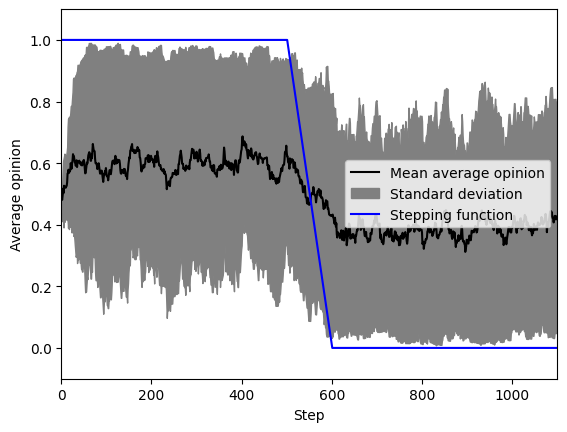

In [2]:
iterations = 2
max_steps = 1100



params = {"N": 40, "k": 3, "w": 1, "alpha": 0.05, "epsilon" : 0.02,
          "pooling" : True, "uniform" : False, "dynamics" : "time_dynamic",
          "measures" : "none", "s_proportion" : 0, "dynamic_point" : 500}

results = mesa.batch_run(Model,parameters=params,number_processes=1,
                         data_collection_period=1,display_progress=True,
                        iterations = iterations, max_steps=max_steps)

results_df = pd.DataFrame(results)


plot_average_opinion(results_df, iterations, max_steps)

plt.xlabel('Step')
plt.ylabel('Average opinion')

# plt.savefig("Figures/Varied_av_op_plots/With_delay/Time_dynamic/100N_3k_1w_0.05alpha_0.02_epsilon.pdf")

In [19]:
params = {"N": 100, "k": 7, "w": 1, "alpha": 0.05, "epsilon" : 0.02,
          "pooling" : True, "uniform" : False, "dynamics" : "time_dynamic",
          "dynamic_point" : 300, "measures" : "none", "s_proportion" : 0}

iterations = 4
max_steps = 600

results = mesa.batch_run(Model,parameters=params,number_processes=1,
                         data_collection_period=1,display_progress=True,
                        iterations = iterations, max_steps=max_steps)

results_df1 = pd.DataFrame(results)

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:09<00:00,  2.26s/it]


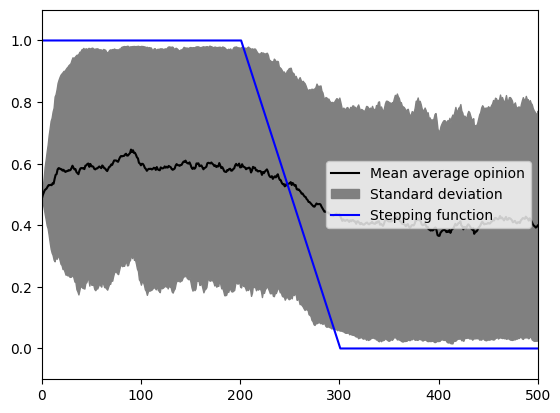

In [18]:
# return_consensus_time(results_df1, 
plot_average_opinion(results_df1, iterations, max_steps)

## Now we need to look at making heatmap plots
#### We want to vary two parameters, and find their consensus times. For now, let's do so for the non-dynamic case
- Ideally we'd want it all to be doable within a function, so we could edit return_consensus_time to have two variable params, and output a matrix

In [39]:
max_steps = 1000
iterations = 5

params = {"N": 50, "k": 5, "w": 1, "alpha": 0.05, "epsilon" : 0.02,
          "pooling" : True, "uniform" : True, "dynamics" : "none",
          "measures" : "none", "s_proportion" : 0}

results = mesa.batch_run(Model,parameters=params,number_processes=1,
                         data_collection_period = 1,display_progress=True,
                        iterations = iterations, max_steps=max_steps)

results_df1 = pd.DataFrame(results)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.42s/it]


In [3]:
# Really, all we need to know is N, K, average_opinion, consensus
# For now lets just see if we can exract N and K

desired_cols = ['N', 'k', 'iteration', 'Step', 'Average_opinion', 'Opinion', 'Majority']

refined_results = [{k: v for k, v in d.items() if k not in desired_cols} for d in results]

In [4]:
mat, stdMat, failMat = return_consensus_time(results_df1, params, iterations, max_steps, variable_parameter1 = "N",
                          variable_parameter2 = "k", reconvergence = False)

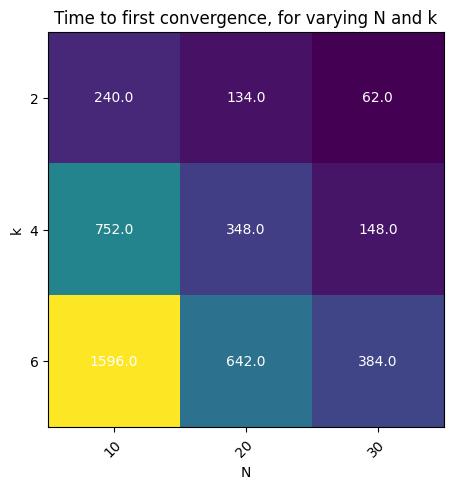

In [5]:
fig, ax = plt.subplots()
im = ax.imshow(mat)

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(params["N"])), labels=params["N"])
ax.set_yticks(np.arange(len(params["k"])), labels=params["k"])

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(params["N"])):
    for j in range(len(params["k"])):
        text = ax.text(j, i, mat[i, j],
                       ha="center", va="center", color="w")

ax.set_title("Time to first convergence, for varying N and k")
fig.tight_layout()
plt.xlabel("N")
plt.ylabel("k")

plt.savefig('Figures/Heatmaps/VaryingNandK/0.6w_0.05alpha_0.02eps.pdf')

plt.show()

### PROBLEM

Step is the model step parameter. This means that once all the agents have had a probability of receiving evidence, it increases by 1

Time is the amount of time that has passed considering each agent step to add 1. That is, for a 100 agent system, when the model-wide step is 5, this time-step would be 500. Is this fair?

We have to consider what this is representing. If the agents move sequentially, i.e, one at a time, then the agent-step should be considered.

If the agents 'move' simultaneously, maybe it is better to consider the model Step.

- If agent-step is used, then the time would be over inflated.
- If model-step is used, then there would be more pooling in the same amount of time for smaller systems. Actually, this is a problem for both. So I think we should revert to model step.

### POTENTIAL SOLUTIONS

- Implement agent step 
- Tweak the model so that it still uses model step, 